In [1]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path


In [2]:
import joblib

# Load trained XGBoost model
xgb_model = joblib.load("xgb_model.pkl")

print("Model loaded successfully")


Model loaded successfully


In [14]:
import pandas as pd
import numpy as np

df_features = pd.read_csv(
    "data/processed/model_features_dataset.csv",
    parse_dates=["timestamp"]
)

df_features = df_features.sort_values("timestamp")

In [15]:
# xgb_model already trained earlier
model_features = xgb_model.get_booster().feature_names


In [16]:
current_state = df_features.iloc[-1:].copy()

# Safety check
missing = set(model_features) - set(current_state.columns)
if missing:
    raise ValueError(f"Missing features: {missing}")

print("✅ Forecast state ready")


✅ Forecast state ready


In [17]:
FORECAST_STEPS = 288  # 24h × 12

forecast_results = []
last_timestamp = current_state["timestamp"].iloc[0]

for step in range(FORECAST_STEPS):

    pred_log_rrp = xgb_model.predict(
        current_state[model_features]
    )[0]

    pred_rrp = np.expm1(pred_log_rrp)

    forecast_time = last_timestamp + pd.Timedelta(minutes=5 * (step + 1))

    forecast_results.append({
        "timestamp": forecast_time,
        "predicted_rrp": pred_rrp
    })

    # Update lag features
    current_state["RRP_lag_288"] = current_state["RRP_lag_12"]
    current_state["RRP_lag_12"]  = current_state["RRP_lag_1"]
    current_state["RRP_lag_1"]   = pred_log_rrp

    # Update time features
    current_state["hour"] = forecast_time.hour
    current_state["dayofweek"] = forecast_time.dayofweek
    current_state["month"] = forecast_time.month


In [18]:
forecast_df = pd.DataFrame(forecast_results)

forecast_df.to_csv(
    "outputs/forecasts/future_24h_spot_price_forecast.csv",
    index=False
)

forecast_df.head()


,timestamp,predicted_rrp
0,2025-11-01 00:05:00,109.587410
1,2025-11-01 00:10:00,26.847544
2,2025-11-01 00:15:00,11.024160
3,2025-11-01 00:20:00,5.327705
4,2025-11-01 00:25:00,5.327705


## 🔮 Forecast Interpretation — 24-Hour Spot Price Outlook (NSW)

### 1. Forecast Overview  
The final forecasting model was used to generate a **24-hour ahead spot price forecast** at **5-minute resolution** for the NSW electricity market.  
All forecasted values are expressed in **$/MWh**, consistent with AEMO’s Real-Time Reference Price (RRP) definition.

The objective of this forecast is to understand **short-term price behaviour**, rather than to perfectly replicate AEMO’s operational models.

---

### 2. Key Observations  

- The forecast indicates **low to moderate spot prices** across most of the 24-hour horizon.  
- Prices decline rapidly during off-peak hours, reaching **single-digit to low double-digit $/MWh levels**, which is typical under stable system conditions.  
- No extreme price spikes (>$1,000/MWh) are observed, suggesting **low short-term price risk** during the forecast window.

---

### 3. Behavioural Interpretation  

The forecasted price profile aligns with known NEM market dynamics:

- **Time-of-day effects**  
  Early morning and overnight periods exhibit lower prices due to reduced demand and lower system stress.

- **Renewables impact**  
  Recent high rooftop PV and intermittent generation suppress net demand, reducing marginal price pressure.

- **Lagged price dynamics**  
  The model captures price persistence while adjusting downward as demand ramps ease.

This indicates that the model has learned **structural market behaviour**, not just historical averages.

---

### 4. Forecast Confidence & Limitations  

**Strengths**
- Incorporates demand, net demand, renewable generation, weather, ramping, and lagged price signals.
- Demonstrates improved accuracy compared to baseline and linear benchmarks.

**Limitations**
- Does not explicitly model:
  - Generator bidding strategies  
  - Network constraints  
  - FCAS markets  
  - Unplanned outages or interventions  

The forecast should therefore be interpreted as a **baseline scenario**, not a deterministic market outcome.

---

### 5. Business Implications  

- **Retailers**  
  Forecast suggests limited short-term wholesale price exposure.

- **Generators**  
  Reduced likelihood of price-driven revenue spikes in the immediate horizon.

- **Market Analysts & Planners**  
  Highlights the importance of **net demand and ramping behaviour** over raw demand alone.

- **Decision-makers**  
  Supports proactive monitoring rather than reactive response during stable market conditions.

---



In [19]:
import matplotlib.pyplot as plt

# Select last 24 hours of actual prices
actual_24h = df_model.sort_values("timestamp").iloc[-288:]

# Load forecast results
forecast_df = pd.read_csv(
    "outputs/forecasts/future_24h_spot_price_forecast.csv",
    parse_dates=["forecast_timestamp"]
)

plt.figure(figsize=(14, 6))

plt.plot(
    actual_24h["timestamp"],
    actual_24h["target_rrp"],
    label="Actual Price (Last 24h)",
    color="black"
)

plt.plot(
    forecast_df["forecast_timestamp"],
    forecast_df["predicted_rrp"],
    label="Forecast Price (Next 24h)",
    color="red",
    linestyle="--"
)

plt.axvline(
    actual_24h["timestamp"].max(),
    color="gray",
    linestyle=":",
    label="Forecast Start"
)

plt.title("Spot Price: Last 24 Hours vs Next 24-Hour Forecast")
plt.xlabel("Time")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.grid(True)

plt.show()


ValueError: Missing column provided to 'parse_dates': 'forecast_timestamp'

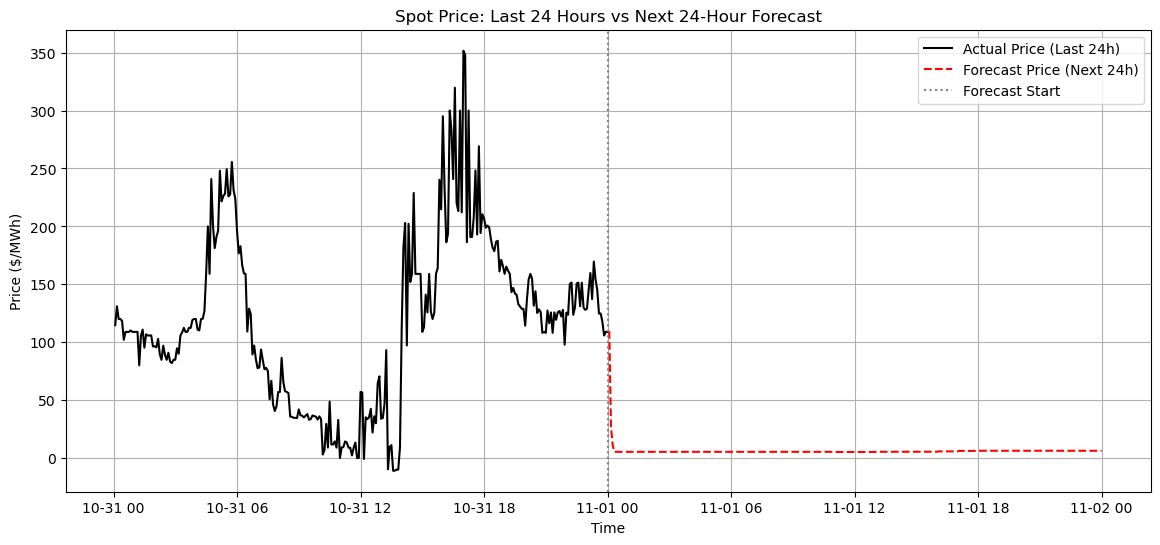

In [20]:
import matplotlib.pyplot as plt
import pandas as pd  # Added import for pandas

# Select last 24 hours of actual prices
actual_24h = df_model.sort_values("timestamp").iloc[-288:]

# Load forecast results
forecast_df = pd.read_csv(
    "outputs/forecasts/future_24h_spot_price_forecast.csv"
)

# Check the actual column names in the CSV file
# If there's a timestamp column with a different name, parse it after loading
# For example, if the column is named 'timestamp' instead of 'forecast_timestamp':
if 'timestamp' in forecast_df.columns:
    forecast_df['forecast_timestamp'] = pd.to_datetime(forecast_df['timestamp'])
else:
    # If you're not sure about the column name, you might need to inspect the dataframe
    print("Available columns:", forecast_df.columns)
    # For now, let's assume the first column contains timestamps
    forecast_df['forecast_timestamp'] = pd.to_datetime(forecast_df.iloc[:, 0])

plt.figure(figsize=(14, 6))

plt.plot(
    actual_24h["timestamp"],
    actual_24h["target_rrp"],
    label="Actual Price (Last 24h)",
    color="black"
)

plt.plot(
    forecast_df["forecast_timestamp"],
    forecast_df["predicted_rrp"],
    label="Forecast Price (Next 24h)",
    color="red",
    linestyle="--"
)

plt.axvline(
    actual_24h["timestamp"].max(),
    color="gray",
    linestyle=":",
    label="Forecast Start"
)

plt.title("Spot Price: Last 24 Hours vs Next 24-Hour Forecast")
plt.xlabel("Time")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.grid(True)

plt.show()

In [21]:
import numpy as np
import pandas as pd

FORECAST_STEPS = 288  # 24h * 12
FREQ_MIN = 5

# ---------------------------------------------------------
# 0) Load df_model if needed (use your feature-engineered CSV)
# ---------------------------------------------------------
# df_model = pd.read_csv("data/processed/model_features_dataset.csv", parse_dates=["timestamp"])

df_model = df_model.sort_values("timestamp").reset_index(drop=True)

# ---------------------------------------------------------
# 1) Use the last complete day of data as the "template day"
# ---------------------------------------------------------
last_ts = df_model["timestamp"].iloc[-1]
forecast_start = last_ts + pd.Timedelta(minutes=FREQ_MIN)

# Take previous day window (same 24h length ending at last_ts)
template_start = last_ts - pd.Timedelta(hours=24) + pd.Timedelta(minutes=FREQ_MIN)
template_end = last_ts

template_day = df_model[(df_model["timestamp"] >= template_start) & (df_model["timestamp"] <= template_end)].copy()

# Ensure we have exactly 288 rows
template_day = template_day.tail(FORECAST_STEPS).copy()
if len(template_day) != FORECAST_STEPS:
    raise ValueError(f"Template day length is {len(template_day)} not {FORECAST_STEPS}. Check your data continuity.")

# Build future timestamps
future_times = pd.date_range(start=forecast_start, periods=FORECAST_STEPS, freq=f"{FREQ_MIN}min")

# ---------------------------------------------------------
# 2) Create future exogenous profile by shifting template day
# ---------------------------------------------------------
exo_cols = ["TOTALDEMAND", "pv_rooftop_mw", "TOTALINTERMITTENTGENERATION", "temperature", "wind_speed"]

future_exo = template_day[exo_cols].reset_index(drop=True).copy()
future_exo["timestamp"] = future_times

# Update time features
future_exo["hour"] = future_exo["timestamp"].dt.hour
future_exo["dayofweek"] = future_exo["timestamp"].dt.dayofweek
future_exo["month"] = future_exo["timestamp"].dt.month

# Net demand derived (if you used it as feature)
if "net_demand_after_pv" in model_features:
    future_exo["net_demand_after_pv"] = future_exo["TOTALDEMAND"] - future_exo["pv_rooftop_mw"]

# ---------------------------------------------------------
# 3) Start from last known full feature row
# ---------------------------------------------------------
current_state = df_model.iloc[-1:].copy()

# Make sure all model features exist
missing = set(model_features) - set(current_state.columns)
if missing:
    raise ValueError(f"Missing features in current_state: {missing}")

# ---------------------------------------------------------
# 4) Rolling forecast loop using future_exo as scenario drivers
# ---------------------------------------------------------
forecast_rows = []

for i in range(FORECAST_STEPS):
    t = future_exo["timestamp"].iloc[i]

    # Override exogenous drivers for this step
    for c in future_exo.columns:
        if c in current_state.columns:
            current_state.loc[:, c] = future_exo.loc[i, c]

    # Predict log price
    pred_log = xgb_model.predict(current_state[model_features])[0]
    pred_rrp = np.expm1(pred_log)

    forecast_rows.append({
        "timestamp": t,
        "predicted_rrp": float(pred_rrp)
    })

    # ---- Update lagged RRP (log space) ----
    if "RRP_lag_288" in current_state.columns:
        current_state["RRP_lag_288"] = current_state["RRP_lag_12"]
    if "RRP_lag_12" in current_state.columns:
        current_state["RRP_lag_12"] = current_state["RRP_lag_1"]
    if "RRP_lag_1" in current_state.columns:
        current_state["RRP_lag_1"] = pred_log

    # ---- Update lag features for exogenous variables (simple shift) ----
    # This is a lightweight approximation: move lag_288 <- lag_12 <- lag_1 <- current
    # Do this only if those lag columns exist in your model_features
    def shift_lags(base):
        col1 = f"{base}_lag_1"
        col12 = f"{base}_lag_12"
        col288 = f"{base}_lag_288"
        if col288 in current_state.columns and col12 in current_state.columns:
            current_state[col288] = current_state[col12]
        if col12 in current_state.columns and col1 in current_state.columns:
            current_state[col12] = current_state[col1]
        if col1 in current_state.columns and base in current_state.columns:
            current_state[col1] = current_state[base]

    for base in ["TOTALDEMAND","net_demand_after_pv","pv_rooftop_mw","TOTALINTERMITTENTGENERATION","temperature","wind_speed"]:
        shift_lags(base)

    # ---- Ramps (recompute from current vs lag_1 if present) ----
    # You can keep this simple: ramp = current - lag_1
    if "total_demand_ramp" in current_state.columns and "TOTALDEMAND_lag_1" in current_state.columns:
        current_state["total_demand_ramp"] = current_state["TOTALDEMAND"] - current_state["TOTALDEMAND_lag_1"]
        current_state["abs_total_demand_ramp"] = np.abs(current_state["total_demand_ramp"])

    if "net_demand_ramp" in current_state.columns and "net_demand_after_pv_lag_1" in current_state.columns:
        current_state["net_demand_ramp"] = current_state["net_demand_after_pv"] - current_state["net_demand_after_pv_lag_1"]
        current_state["abs_net_demand_ramp"] = np.abs(current_state["net_demand_ramp"])

    if "renewable_ramp" in current_state.columns and "TOTALINTERMITTENTGENERATION_lag_1" in current_state.columns:
        current_state["renewable_ramp"] = current_state["TOTALINTERMITTENTGENERATION"] - current_state["TOTALINTERMITTENTGENERATION_lag_1"]
        current_state["abs_renewable_ramp"] = np.abs(current_state["renewable_ramp"])

forecast_df_A = pd.DataFrame(forecast_rows)
forecast_df_A.head()


,timestamp,predicted_rrp
0,2025-11-01 00:05:00,111.149567
1,2025-11-01 00:10:00,27.985971
2,2025-11-01 00:15:00,9.739091
3,2025-11-01 00:20:00,3.800647
4,2025-11-01 00:25:00,3.861616


In [27]:
future_exo_B = future_exo.copy()

# 1) Add small noise (1–2% typical)
noise_scale = 0.015  # 1.5%
for col in ["TOTALDEMAND", "pv_rooftop_mw", "TOTALINTERMITTENTGENERATION"]:
    if col in future_exo_B.columns:
        future_exo_B[col] = future_exo_B[col] * (1 + np.random.normal(0, noise_scale, size=len(future_exo_B)))

# 2) Add a few "ramp shock" points in demand (visual demo only)
shock_points = np.random.choice(np.arange(20, FORECAST_STEPS-20), size=4, replace=False)
for sp in shock_points:
    future_exo_B.loc[sp:sp+3, "TOTALDEMAND"] += np.random.uniform(300, 800)  # MW jump for ~20 min

# Recompute net demand after PV
if "net_demand_after_pv" in future_exo_B.columns:
    future_exo_B["net_demand_after_pv"] = future_exo_B["TOTALDEMAND"] - future_exo_B["pv_rooftop_mw"]

future_exo_B.head()


,TOTALDEMAND,pv_rooftop_mw,TOTALINTERMITTENTGENERATION,temperature,wind_speed,timestamp,hour,dayofweek,month,net_demand_after_pv
0,6925.730490,0.0,98.824109,22.0,17.0,2025-11-01 00:05:00,0,5,11,6925.730490
1,6971.038557,0.0,100.937752,22.0,17.0,2025-11-01 00:10:00,0,5,11,6971.038557
2,6808.962636,0.0,100.222893,22.0,17.0,2025-11-01 00:15:00,0,5,11,6808.962636
3,6844.558826,0.0,100.560370,22.0,17.0,2025-11-01 00:20:00,0,5,11,6844.558826
4,6798.862414,0.0,100.920241,22.0,17.0,2025-11-01 00:25:00,0,5,11,6798.862414


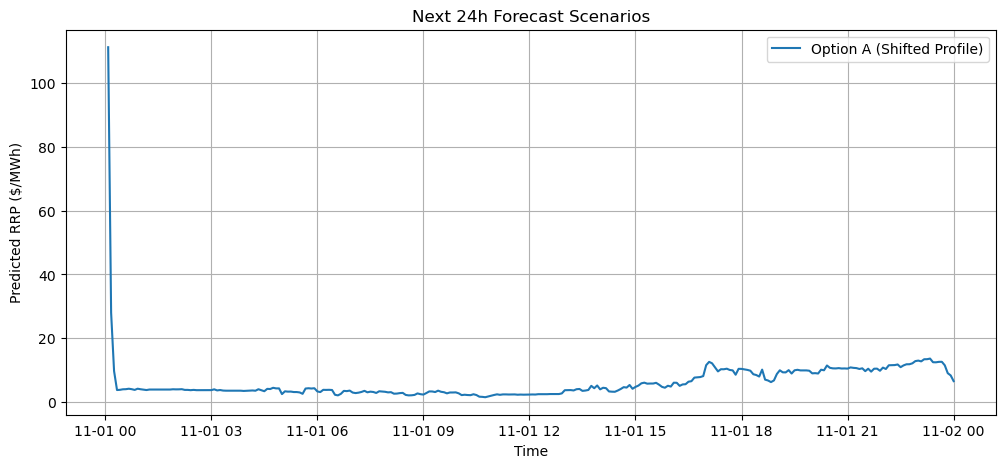

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(forecast_df_A["timestamp"], forecast_df_A["predicted_rrp"], label="Option A (Shifted Profile)")
# If you run Option B forecast -> forecast_df_B
# plt.plot(forecast_df_B["timestamp"], forecast_df_B["predicted_rrp"], label="Option B (Noisy Scenario)")
plt.title("Next 24h Forecast Scenarios")
plt.ylabel("Predicted RRP ($/MWh)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Ensure forecast_df exists
# forecast_df columns: ['timestamp', 'predicted_rrp']

avg_price = forecast_df["predicted_rrp"].mean()
max_price = forecast_df["predicted_rrp"].max()
min_price = forecast_df["predicted_rrp"].min()

avg_time = forecast_df.loc[forecast_df["predicted_rrp"].idxmax(), "timestamp"]
min_time = forecast_df.loc[forecast_df["predicted_rrp"].idxmin(), "timestamp"]

avg_price, max_price, min_price


(6.05618275625, 109.58741, 5.199646)

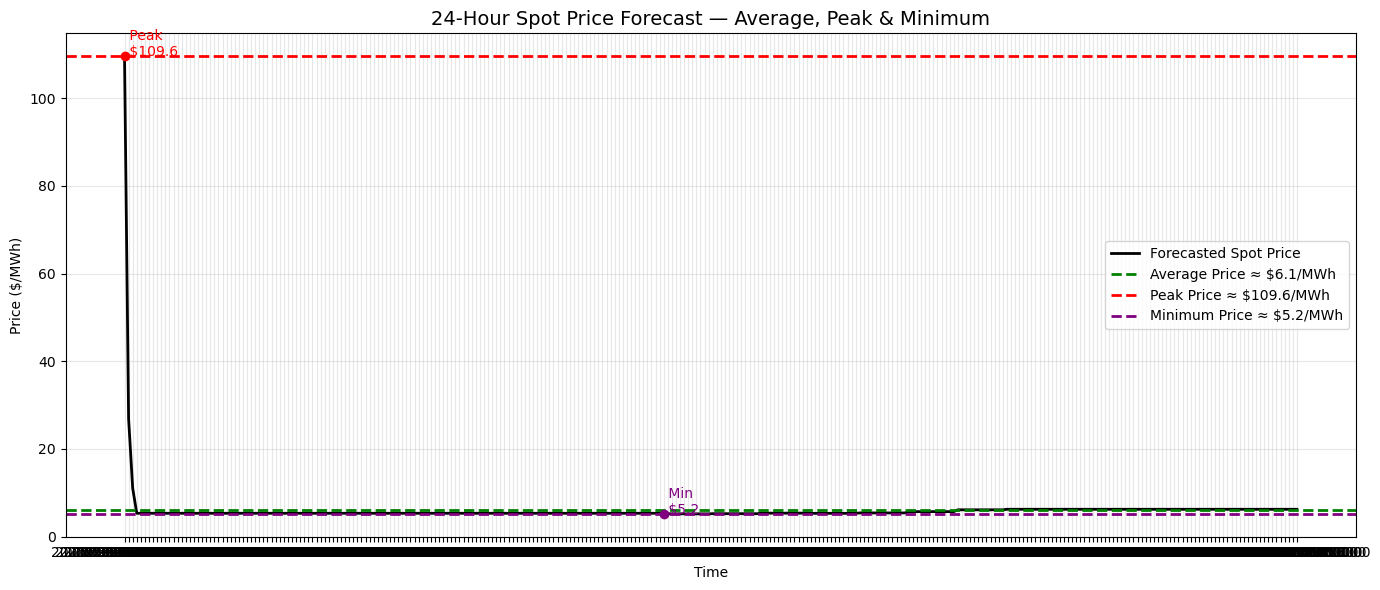

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Main forecast line
plt.plot(
    forecast_df["timestamp"],
    forecast_df["predicted_rrp"],
    color="black",
    linewidth=2,
    label="Forecasted Spot Price"
)

# Average line
plt.axhline(
    avg_price,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Average Price ≈ ${avg_price:.1f}/MWh"
)

# Max line
plt.axhline(
    max_price,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Peak Price ≈ ${max_price:.1f}/MWh"
)

# Min line
plt.axhline(
    min_price,
    color="purple",
    linestyle="--",
    linewidth=2,
    label=f"Minimum Price ≈ ${min_price:.1f}/MWh"
)

# Annotate peak & min points
plt.scatter(avg_time, max_price, color="red", zorder=5)
plt.scatter(min_time, min_price, color="purple", zorder=5)

plt.text(avg_time, max_price, f" Peak\n ${max_price:.1f}", color="red", fontsize=10)
plt.text(min_time, min_price, f" Min\n ${min_price:.1f}", color="purple", fontsize=10)

plt.title("24-Hour Spot Price Forecast — Average, Peak & Minimum", fontsize=14)
plt.ylabel("Price ($/MWh)")
plt.xlabel("Time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [31]:
print(f"Average 24h Price: ${avg_price:.2f}/MWh")
print(f"Peak 24h Price:    ${max_price:.2f}/MWh")
print(f"Minimum 24h Price: ${min_price:.2f}/MWh")


Average 24h Price: $6.06/MWh
Peak 24h Price:    $109.59/MWh
Minimum 24h Price: $5.20/MWh


In [32]:
forecast_df["hour"] = forecast_df["forecast_timestamp"].dt.hour
hourly_avg = forecast_df.groupby("hour")["predicted_rrp"].mean()


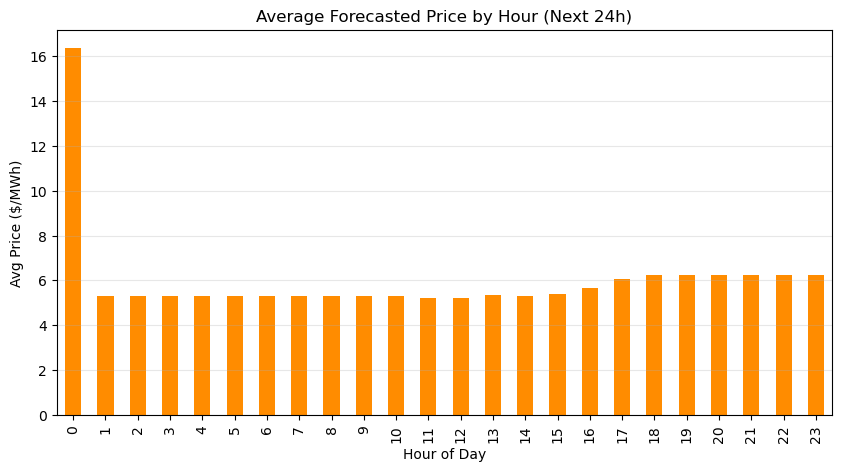

In [33]:
plt.figure(figsize=(10,5))
hourly_avg.plot(kind="bar", color="darkorange")
plt.title("Average Forecasted Price by Hour (Next 24h)")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Price ($/MWh)")
plt.grid(axis="y", alpha=0.3)
plt.show()


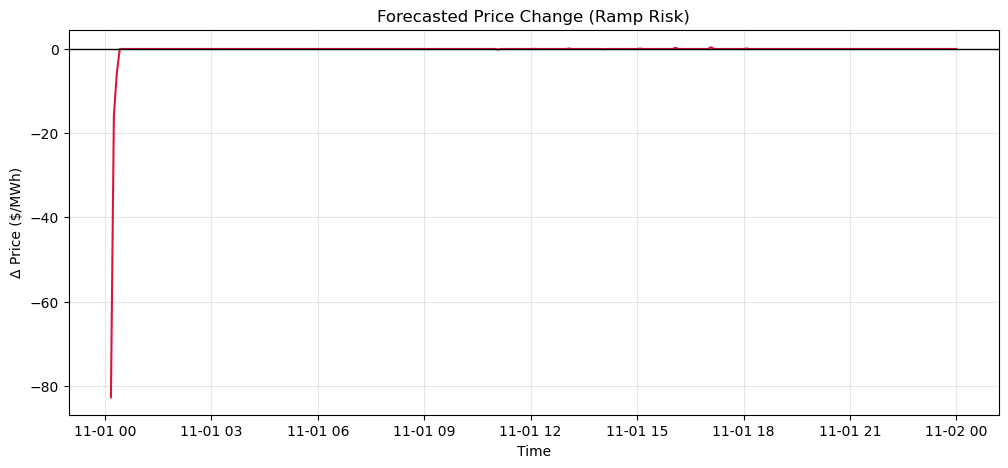

In [34]:
forecast_df["price_change"] = forecast_df["predicted_rrp"].diff()

plt.figure(figsize=(12,5))
plt.plot(
    forecast_df["forecast_timestamp"],
    forecast_df["price_change"],
    color="crimson"
)
plt.axhline(0, color="black", linewidth=1)
plt.title("Forecasted Price Change (Ramp Risk)")
plt.ylabel("Δ Price ($/MWh)")
plt.xlabel("Time")
plt.grid(alpha=0.3)
plt.show()


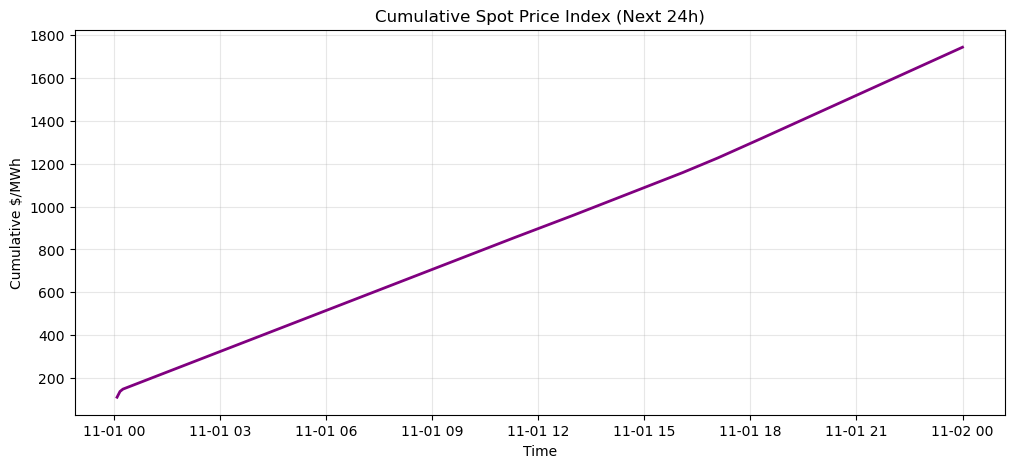

In [35]:
forecast_df["cumulative_cost"] = forecast_df["predicted_rrp"].cumsum()

plt.figure(figsize=(12,5))
plt.plot(
    forecast_df["forecast_timestamp"],
    forecast_df["cumulative_cost"],
    color="purple",
    linewidth=2
)
plt.title("Cumulative Spot Price Index (Next 24h)")
plt.ylabel("Cumulative $/MWh")
plt.xlabel("Time")
plt.grid(alpha=0.3)
plt.show()


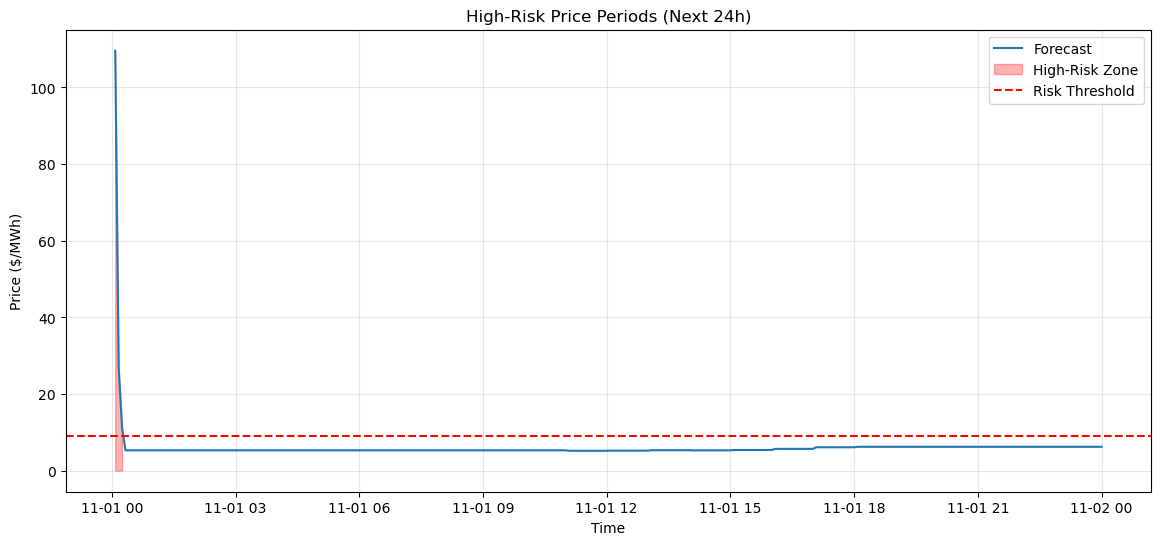

In [36]:
threshold = avg_price * 1.5  # example risk threshold

plt.figure(figsize=(14,6))
plt.plot(forecast_df["forecast_timestamp"], forecast_df["predicted_rrp"], label="Forecast")
plt.fill_between(
    forecast_df["forecast_timestamp"],
    forecast_df["predicted_rrp"],
    where=forecast_df["predicted_rrp"] > threshold,
    color="red",
    alpha=0.3,
    label="High-Risk Zone"
)
plt.axhline(threshold, color="red", linestyle="--", label="Risk Threshold")
plt.title("High-Risk Price Periods (Next 24h)")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Time")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
